In [1]:
from IPython.display import Image
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import sys



In [2]:
df = pd.read_csv('../data/pima-indians-diabetes.data.csv',header=None)


In [3]:
df.rename(columns={0:'Pregnancies',1:'Glucose',2:'BloodPressure',3:'SkinThickness',4:'Insulin',
                5:'BMI',6:'PedigreeFn',7:'Age',8:'class'},inplace=True)

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,PedigreeFn,Age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
y = df.iloc[:,8]
X = df.iloc[:,:8]

In [6]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

 1) Glucose                        0.248542
 2) BMI                            0.153839
 3) Age                            0.152530
 4) PedigreeFn                     0.125997
 5) BloodPressure                  0.095099
 6) Pregnancies                    0.082426
 7) SkinThickness                  0.072725
 8) Insulin                        0.068843


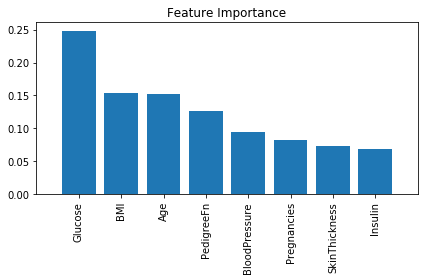

In [7]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = X.columns

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

In [8]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold criterion:', 
      X_selected.shape[1])

Number of features that meet this threshold criterion: 4


In [9]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) Glucose                        0.248542
 2) BMI                            0.153839
 3) Age                            0.152530
 4) PedigreeFn                     0.125997


In [10]:
X_select = X[['Glucose','BMI','Age','PedigreeFn']]

In [11]:
X_select.head()

,Glucose,BMI,Age,PedigreeFn
0,148,33.6,50,0.627
1,85,26.6,31,0.351
2,183,23.3,32,0.672
3,89,28.1,21,0.167
4,137,43.1,33,2.288


In [12]:
from sklearn.preprocessing import StandardScaler , Normalizer ,MinMaxScaler , normalize

In [13]:
# from sklearn.preprocessing import MinMaxScaler

# mms = MinMaxScaler()
# X_train_norm = mms.fit_transform(X_train)
# X_test_norm = mms.transform(X_test)

In [14]:
# from sklearn.preprocessing import StandardScaler

# stdsc = StandardScaler()
# X_train_std = stdsc.fit_transform(X_train)
# X_test_std = stdsc.transform(X_test)

In [15]:
transformer = Normalizer().fit(X_select)  # fit does nothing.
transformer

X_normz= transformer.transform(X_select)

In [16]:
X_train, X_test, y_train, y_test =\
    train_test_split(X_normz, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

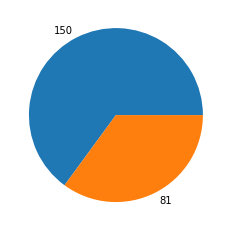

In [17]:
m = np.bincount(y_test)
n = np.bincount(y_train)
plt.pie(m,labels=m)  
# plt.pie(n,labels=n)
pass

In [18]:
from xgboost import XGBClassifier

In [19]:
model=XGBClassifier()
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.658008658008658

## Grid Search

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report,f1_score
from prettytable import PrettyTable
from sklearn.model_selection import cross_val_score ,StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from datetime import datetime

In [21]:
# A parameter grid for XGBoost
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

parameters = {
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0]
}

In [22]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                  silent=True, nthread=1)

skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)

In [23]:
# folds = 3
# param_comb = 5

grid_search  = GridSearchCV(estimator=xgb, 
                                   param_grid=parameters, 
                                   scoring='roc_auc', n_jobs=4, 
                                   cv=3, 
                                   verbose=3)

grid_search .fit(X_normz, y)


Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   52.3s
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed:   58.1s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.02, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=600, n_jobs=1,
                                     nthread=1, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=True,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'gamma': [0.5, 1, 1.5, 2, 5],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'subsample': [0.6, 0.8, 1.0]},
          

In [24]:
# Best estimator
print(grid_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.6, verbosity=1)


In [25]:
xgb_tuned = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.6, verbosity=1)

In [26]:
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.6, verbosity=1)

In [27]:
predicted_labels = xgb_tuned.predict(X_test)

In [28]:
train_score = round(model.score(X_train, y_train),2)
test_score = round(model.score(X_test,y_test),2)
Accuracy = round(accuracy_score(y_test, predicted_labels),2)
F1score = round(f1_score(y_test, predicted_labels),2)
Recall = round(recall_score(y_test, predicted_labels),2)
Precision = round(precision_score(y_test, predicted_labels),2)
t = PrettyTable(['Train_score','Test_score','Accuracy','F1score','Recall','Precision'])
t.add_row([train_score,test_score,Accuracy,F1score,Recall,Precision])
print(t)

+-------------+------------+----------+---------+--------+-----------+
| Train_score | Test_score | Accuracy | F1score | Recall | Precision |
+-------------+------------+----------+---------+--------+-----------+
|     0.83    |    0.66    |   0.65   |   0.28  |  0.2   |    0.48   |
+-------------+------------+----------+---------+--------+-----------+


## RandomizedSearchCV

In [38]:
# folds = 3
# param_comb = 5

random_search  = RandomizedSearchCV(estimator=xgb, 
                                   param_distributions=parameters, 
                                   scoring='roc_auc', n_jobs=4, 
                                   cv=4, 
                                   verbose=3)

random_search .fit(X_normz, y)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   14.3s finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=600,
                                           n_jobs=1, nthread=1,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=True, subsample=1,
                                           verbosity=1),
                   iid='depr

In [39]:
# Best estimator
print(random_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.5,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.8, verbosity=1)


In [40]:
xgb_tuned_random = random_search.best_estimator_

In [41]:
xgb_tuned_random.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.5,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.8, verbosity=1)

In [42]:
predicted_labels = xgb_tuned_random.predict(X_test)

In [43]:
train_score = round(model.score(X_train, y_train),2)
test_score = round(model.score(X_test,y_test),2)
Accuracy = round(accuracy_score(y_test, predicted_labels),2)
F1score = round(f1_score(y_test, predicted_labels),2)
Recall = round(recall_score(y_test, predicted_labels),2)
Precision = round(precision_score(y_test, predicted_labels),2)
t = PrettyTable(['Train_score','Test_score','Accuracy','F1score','Recall','Precision'])
t.add_row([train_score,test_score,Accuracy,F1score,Recall,Precision])
print(t)

+-------------+------------+----------+---------+--------+-----------+
| Train_score | Test_score | Accuracy | F1score | Recall | Precision |
+-------------+------------+----------+---------+--------+-----------+
|     0.83    |    0.66    |   0.67   |   0.34  |  0.25  |    0.57   |
+-------------+------------+----------+---------+--------+-----------+


## Confusion Matrix

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score ,roc_auc_score ,confusion_matrix ,roc_curve

In [44]:
cm = confusion_matrix(y_test, predicted_labels)
print(cm)

[[135  15]
 [ 61  20]]


In [45]:
precision_score(y_test, predicted_labels)

0.5714285714285714

In [46]:
roc_auc_score(y_test, predicted_labels)

0.5734567901234568

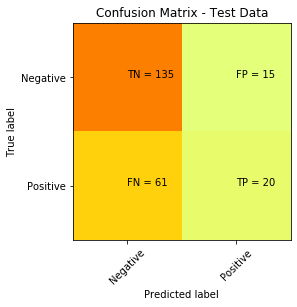

In [47]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [52]:
from sklearn.metrics import roc_curve ,auc

In [53]:
fpr, tpr, _ = roc_curve(y_test, predicted_labels)
roc_auc = auc(fpr, tpr)

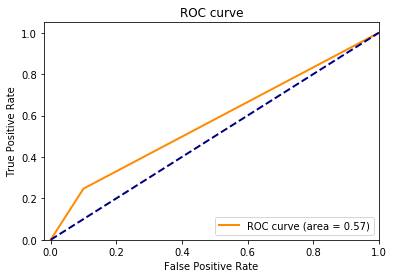

In [54]:
#xgb.plot_importance(gbm)
#plt.show()
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()